<a href="https://colab.research.google.com/github/Anuj347/Predictive-maintenance/blob/main/Predictive_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Fault detection in Wind Turbine**

**Background**

The wind energy sector has experienced significant growth in recent years, driven by the global shift toward sustainable energy solutions. As wind turbine (WT) systems become larger and more complex, ensuring their operational efficiency and minimizing downtime have become more critical than ever. In this context, fault detection and predictive maintenance have emerged as vital components for optimizing turbine performance, reducing operational costs, and extending the lifespan of the equipment.

This study examines the WT-IIoT dataset, sourced from [Kaggle](//https://colab.research.google.com/drive/1--d22pkDgX4pozWn-mHMRXry19u_xWFY#scrollTo=b5B0EZBRJXJB&line=7&uniqifier=1). The dataset, enriched with real-time data from wind turbine Supervisory Control and Data Acquisition (SCADA) systems, provides a unique opportunity to explore the intricacies of fault classification. SCADA systems collect valuable operational data, allowing for early detection of potential faults and anomalies, which can prevent costly breakdowns and improve overall turbine reliability.

By leveraging advanced data analytics and machine learning techniques, this study seeks to uncover patterns and trends that can enhance predictive maintenance strategies. This, in turn, can lead to more effective scheduling of maintenance activities, reducing unplanned outages, improving energy output, and contributing to a more resilient and sustainable energy grid. The insights gained from this dataset could drive significant advancements in the wind energy industry, making turbines more reliable and efficient in meeting the growing demand for clean energy.


**Dataset**

The dataset covers a wide range of SCADA measurements collected between April 2014 and April 2015, offering a detailed overview of the wind turbine's operational conditions. The SCADA variables include key parameters such as reactive power, blade angle, nacelle position, and temperatures of crucial components like the bearing, rotor, and stator. Although limited, the meteorological data includes minimum, maximum, and average wind speeds. Furthermore, the dataset contains status logs that provide insights into the turbine's operational state, with variables such as main status, sub-status, full status, status text, service, and fault messages.

**Description of features in the SCADA dataset**

1.   **Error'**: Represents the occurrence of faults in the wind turbine system.
2.   **'WEC: ava. windspeed', 'WEC: max. windspeed', 'WEC: min. windspeed'**: Meteorological variables indicating the availability, maximum, and minimum wind speeds.
3. **'WEC: ava. Rotation', 'WEC: max. Rotation', 'WEC: min. Rotation'**: Rotation-related variables providing information about the turbine's rotational behavior.
4. **'WEC: ava. Power', 'WEC: max. Power', 'WEC: min. Power'**: Power-related variables denoting the availability, maximum, and minimum power generated by the wind turbine.
5. **'WEC: Operating Hours', 'WEC: Production kWh', 'WEC: Production minutes'**: Variables offering insights into the turbine's operating hours and production metrics.
6. **'WEC: ava. reactive Power', 'WEC: max. reactive Power', 'WEC: min. reactive Power'**: Reactive power-related variables indicating availability, maximum, and minimum reactive power.
7. **'WEC: ava. available P from wind', 'WEC: ava. available P technical reasons', 'WEC: ava. Available P force majeure reasons', 'WEC: ava. Available P force external reasons'**: Variables categorizing available power based on various factors, such as wind, technical issues, force majeure, and external reasons.
8. **'WEC: ava. blade angle A'**: Availability of blade angle A, an essential parameter for turbine operation.
9. **'Sys 1 inverter 1 cabinet temp.', 'Sys 1 inverter 2 cabinet temp.', ... 'Inverter std dev'**: Various temperature-related variables, providing insights into the temperature distribution across different components of the wind turbine.



*This study aims to harness these diverse features to develop a robust fault detection model to detect and classify the failures that can arise during wind turbine operation. Our data include the following failure types:*

1. **Feeding failure 'FF'**: which includes zero crossing in inverters, external shut down of inverters, inverters overload, load shedding in inverters.

2. **Excitation failure 'EF'**: correspanding to Overvoltage in DC-link.

3. **Main failure 'MF'**: which includes start delay, undervoltage in L1 or L2.

4. **Air gap monitoring failure 'AF'**: triggered by sensor 1 in blade C.

5. **Generator heating failure 'GF'**: which can happen in Hygrostat inverter or Hygrostat rectifier or Isometer.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

Importing all the dataset relevant for this study

In [4]:
fault_data = pd.read_csv("fault_data.csv", parse_dates=["DateTime"], index_col="DateTime")
scada_data = pd.read_csv("scada_data.csv", parse_dates=["DateTime"], index_col="DateTime")
status_data = pd.read_csv("status_data.csv", parse_dates=["Time"], dayfirst=True, index_col="Time")

In [5]:
fault_data.head()

,Time,Fault
DateTime,,
2014-05-14 14:39:44,1.400096e+09,GF
2014-05-14 14:50:24,1.400097e+09,GF
2014-05-14 14:58:56,1.400098e+09,GF
2014-05-14 15:09:36,1.400098e+09,GF
2014-05-14 15:20:16,1.400099e+09,GF


In [6]:
scada_data.head()

,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
DateTime,,,,,,,,,,,,,,,,,,,,,
2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.0,0.02,0.0,0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.0,0.01,0.0,0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.0,0.04,0.0,0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.0,0.08,0.0,0,0,...,23,21,25,12,14,24,34,2501,25.272728,1.103713
2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.0,0.05,0.0,0,0,...,23,21,25,12,14,23,34,2501,25.272728,1.103713


In [7]:
status_data.head()

,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0
Time,,,,,,,,
2014-04-24 12:37:38,0,0,0 : 0,Turbine in operation,1,False,False,7.4
2014-04-25 19:27:24,71,104,71 : 104,Insulation monitoring : Insulation fault Phase U2,6,False,True,20.5
2014-04-26 09:30:13,8,0,8 : 0,Maintenance,6,True,False,17.1
2014-04-26 10:05:19,8,0,8 : 0,Maintenance,6,False,False,8.7
2014-04-26 10:05:25,8,0,8 : 0,Maintenance,6,True,False,10.6


In [8]:
print("Fault data shape:", fault_data.shape)
print("SCADA data shape:", scada_data.shape)
print("Status data shape:", status_data.shape)

Fault data shape: (553, 2)
SCADA data shape: (49027, 65)
Status data shape: (1849, 8)


**Analysis**


The fault and status data have fewer samples compared to the full SCADA dataset, as they only record timestamps when an actual failure occurred in the wind turbine. This is important to keep in mind when integrating the fault features into the SCADA data.

In [9]:
# missing data
print(f"Fault data missing: {(fault_data.isna().sum()).sum()}")
print(f"SCADA data missing: {(scada_data.isna().sum()).sum()}")
print(f"Status data missing: {(status_data.isna().sum()).sum()}")

Fault data missing: 0
SCADA data missing: 0
Status data missing: 0


In [10]:
# datetime ranges
print(f"Fault data datetime range from {fault_data.index[0]} to {fault_data.index[-1]}")
print(f"SCADA data datetime range from {scada_data.index[0]} to {scada_data.index[-1]}")
print(f"Status data datetime range from {status_data.index[0]} to {status_data.index[-1]}")

Fault data datetime range from 2014-05-14 14:39:44 to 2015-01-15 23:09:20
SCADA data datetime range from 2014-05-01 00:00:00 to 2015-04-09 00:00:00
Status data datetime range from 2014-04-24 12:37:38 to 2015-04-28 22:18:19


**Analysis**

The status data spans a broader datetime range compared to the SCADA data. As a result, when merging the status values with the SCADA and fault datasets, we'll need to discard some of the additional status records not present in the other two datasets. Consequently, the datetime range for our study will be limited to the period from 2014-05-01 00:00:00 to 2015-04-09 00:00:00.

In [11]:
from datetime import datetime

print("Fault data date/time from DateTime:", fault_data.index[0])
print("Fault data date/time from Timestamp:", datetime.fromtimestamp(fault_data["Time"][0]))

Fault data date/time from DateTime: 2014-05-14 14:39:44
Fault data date/time from Timestamp: 2014-05-14 19:39:44


<ipython-input-11-5862f51a6fe1>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Fault data date/time from Timestamp:", datetime.fromtimestamp(fault_data["Time"][0]))


In [12]:
from datetime import datetime

print("Fault data date/time from DateTime:", scada_data.index[0])
print("Fault data date/time from Timestamp:", datetime.fromtimestamp(scada_data["Time"][0]))

Fault data date/time from DateTime: 2014-05-01 00:00:00
Fault data date/time from Timestamp: 2014-05-01 05:00:48


<ipython-input-12-113f9ee2b7e9>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Fault data date/time from Timestamp:", datetime.fromtimestamp(scada_data["Time"][0]))


**Analysis**


In both the fault and SCADA datasets, the recorded datetime values appear to be delayed by 6 hours compared to the actual timestamps. The status data also reflects these lagging datetime values. Since the timestamps in the fault and SCADA datasets seem more accurate, we'll use them as the primary index and adjust the timestamps in the status data accordingly later on.

In [13]:
# change the indexes using "TIME" timestamps
# convert to readable datetimes
fault_data.index = fault_data.Time.apply(lambda x: datetime.fromtimestamp(x))
fault_data = fault_data.drop(["Time"], axis=1)

scada_data.index = scada_data.Time.apply(lambda x: datetime.fromtimestamp(x))
scada_data = scada_data.drop(["Time"], axis=1)

In [14]:
# Rechecking missing values
print("Missing values in Fault data:", (fault_data.isna().sum()).sum())
print("Missing values in SCADA data:", (scada_data.isna().sum()).sum())
print("Missing values in Status data:", (status_data.isna().sum()).sum())

Missing values in Fault data: 0
Missing values in SCADA data: 0
Missing values in Status data: 0


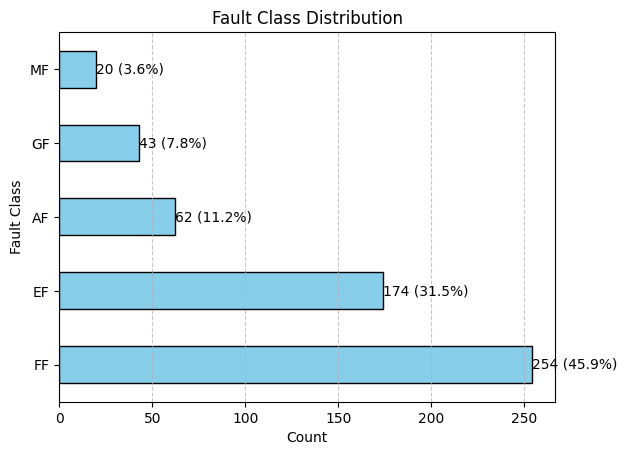

In [17]:
import matplotlib.pyplot as plt

fault_distribution = fault_data["Fault"].value_counts()
fault_percentage = (fault_distribution / fault_distribution.sum()) * 100

ax = fault_distribution.plot(kind="barh", color='skyblue', edgecolor='black')

for index, value in enumerate(fault_distribution):
    percentage = fault_percentage.iloc[index]
    ax.text(value, index, f'{value} ({percentage:.1f}%)', va='center')

plt.title("Fault Class Distribution")
plt.xlabel("Count")
plt.ylabel("Fault Class")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()


**Analysis**


Data shows that "EF" and "FF" are the most common fault types, suggesting they frequently occur in wind turbines. In contrast, "MF," "GF," and "AF" faults are less common, indicating they may be rare or linked to severe failures, only arising in extreme circumstances.

In [18]:
#Check for duplicated datetimes
print("Duplicated datetimes in Fault data:", (fault_data.index.duplicated()).sum())
print("Duplicated datetimes in SCADA data:", (scada_data.index.duplicated()).sum())
print("Duplicated datetimes in Status data:", (status_data.index.duplicated()).sum())

Duplicated datetimes in Fault data: 107
Duplicated datetimes in SCADA data: 6
Duplicated datetimes in Status data: 34


**Analysis**


Duplicates are observed across all datasets, though their significance varies. In the SCADA data, duplicated records can be removed without issue. However, in the status and fault data, duplicated datetime records represent instances where two or more fault types occur simultaneously in a wind turbine, making these occurrences vital for the analysis.

To handle datetime instances with multiple fault types, one-hot encoding will be applied to represent each fault type at a given datetime.

In [19]:
# drop duplicated instances in SCADA data
scada_data = scada_data[~scada_data.index.duplicated()]

**Multiple faults occurances**

In [22]:
faults = fault_data.groupby(fault_data.index)['Fault'].apply(lambda x: ','.join(x.astype(str)))
fault_classes = faults.str.get_dummies(sep=',')
fault_classes.set_index(faults.index)
fault_classes.head()

,AF,EF,FF,GF,MF
Time,,,,,
2014-05-14 19:39:44,0,0,0,1,0
2014-05-14 19:50:24,0,0,0,1,0
2014-05-14 19:58:56,0,0,0,1,0
2014-05-14 20:09:36,0,0,0,1,0
2014-05-14 20:20:16,0,0,0,1,0


In [23]:
# check which fault can occurs at the same time
fault_classes[['AF', 'EF', 'FF', 'GF', 'MF']].astype(str).agg(''.join, axis=1).value_counts()

,count
00100,159
01100,95
01000,79
10000,50
00010,43
10001,12
00001,8


**Analysis**


Instances have been observed where "EF" and "FF" faults occur simultaneously in the wind turbine, as well as cases where "AF" and "MF" faults happen together.

In [26]:
# we consider that all instances not present in fault are normal working conditions (No fault)
fault_column = fault_data[~fault_data.index.duplicated()].reindex(scada_data.index, fill_value="NF")

In [27]:
fault_column["Fault"].value_counts()

,count
Fault,
NF,48575
EF,174
FF,159
AF,62
GF,43
MF,8


**Analysis**


It is evident that the fault classes are highly imbalanced, with the non-fault class accounting for 99% of the data. To perform a classification task, it will be necessary to take a smaller sample of the non-fault class and apply rebalancing techniques to increase the number of failure instances. Additionally, with only 8 instances of the MF fault, this scarcity is likely to pose challenges when training the models.

# **Exploratory data analysis**

In [28]:
# combine fault data with scada data
combined_data = scada_data.merge(fault_column, on="Time", how="left")

In [29]:
combined_data.columns

Index(['Error', 'WEC: ava. windspeed', 'WEC: max. windspeed',
       'WEC: min. windspeed', 'WEC: ava. Rotation', 'WEC: max. Rotation',
       'WEC: min. Rotation', 'WEC: ava. Power', 'WEC: max. Power',
       'WEC: min. Power', 'WEC: ava. Nacel position including cable twisting',
       'WEC: Operating Hours', 'WEC: Production kWh',
       'WEC: Production minutes', 'WEC: ava. reactive Power',
       'WEC: max. reactive Power', 'WEC: min. reactive Power',
       'WEC: ava. available P from wind',
       'WEC: ava. available P technical reasons',
       'WEC: ava. Available P force majeure reasons',
       'WEC: ava. Available P force external reasons',
       'WEC: ava. blade angle A', 'Sys 1 inverter 1 cabinet temp.',
       'Sys 1 inverter 2 cabinet temp.', 'Sys 1 inverter 3 cabinet temp.',
       'Sys 1 inverter 4 cabinet temp.', 'Sys 1 inverter 5 cabinet temp.',
       'Sys 1 inverter 6 cabinet temp.', 'Sys 1 inverter 7 cabinet temp.',
       'Sys 2 inverter 1 cabinet temp.', 'Sys

In [30]:
# rename columns for simplification
combined_data.columns = ['Error', 'avg_ws', 'max_ws', 'min_ws', 'avg_rot', 'max_rot','min_rot',
                         'avg_power', 'max_power', 'min_power', 'avg_Nacel_position', 'Operating Hours',
                         'Production(kWh)', 'Production(min)', 'avg_reactive_power', 'max_reactive_power',
                         'min_reactive_power', 'avg_available_power_fw', 'avg_available_power_tr',
                         'avg_available_power_mr', 'avg_available_power_er', 'avg_blade_angle_A',
                         'temp_inverter11', 'temp_inverter12', 'temp_inverter13', 'temp_inverter14',
                         'temp_inverter15', 'temp_inverter16', 'temp_inverter17', 'temp_inverter21',
                         'temp_inverter22', 'temp_inverter23', 'temp_inverter24', 'temp_inverter25',
                         'temp_inverter26', 'temp_inverter27', 'temp_Spinner','temp_Front_bearing',
                         'temp_Rear_bearing', 'temp_Pitch_cabinet_blade_A', 'temp_Pitch_cabinet_blade_B',
                         'temp_Pitch_cabinet_blade_C', 'temp_Blade_A', 'temp_Blade_B', 'temp_Blade_C',
                         'temp_Rotor1', 'temp_Rotor2', 'temp_stator1', 'temp_stator2', 'temp_nacelle_ambient1',
                         'temp_nacelle_ambient2','temp_nacelle', 'temp_nacelle_cabinet', 'temp_main_carrier',
                         'temp_rectifier_cabinet', 'temp_yaw_inverter_cabinet', 'temp_fan_inverter_cabinet',
                         'temp_ambient', 'temp_tower', 'temp_control_cabinet', 'temp_Transformer', 'avg_RTU_setpoint1',
                         'Inverter averages', 'Inverter std dev', 'Fault']

In [31]:
# check the Error column
combined_data["Error"].value_counts()

,count
Error,
0,48722
246,164
10,35
20,18
50,18
90,14
30,13
80,9
70,9


**Analysis**


The "Error" column in the SCADA data contains more than five categories, but for this study, only the five fault categories identified earlier from the fault data will be considered. The presence of multiple error categories suggests that this column may also indicate the type of fault occurring in the wind turbine, similar to the fault classes extracted previously.

For the purposes of a classification task, it is important to remove this column before training the models, as it directly correlates with the target variable (fault type) and could lead to data leakage, where the model inadvertently learns from information that would not be available during actual predictions.

# **Power/windspeed/rotation relationship**

In [32]:
ws_rot_power_features = combined_data[['avg_ws', 'max_ws', 'min_ws', 'avg_rot', 'max_rot','min_rot',
                         'avg_power', 'max_power', 'min_power', 'avg_reactive_power', 'max_reactive_power',
                         'min_reactive_power']]

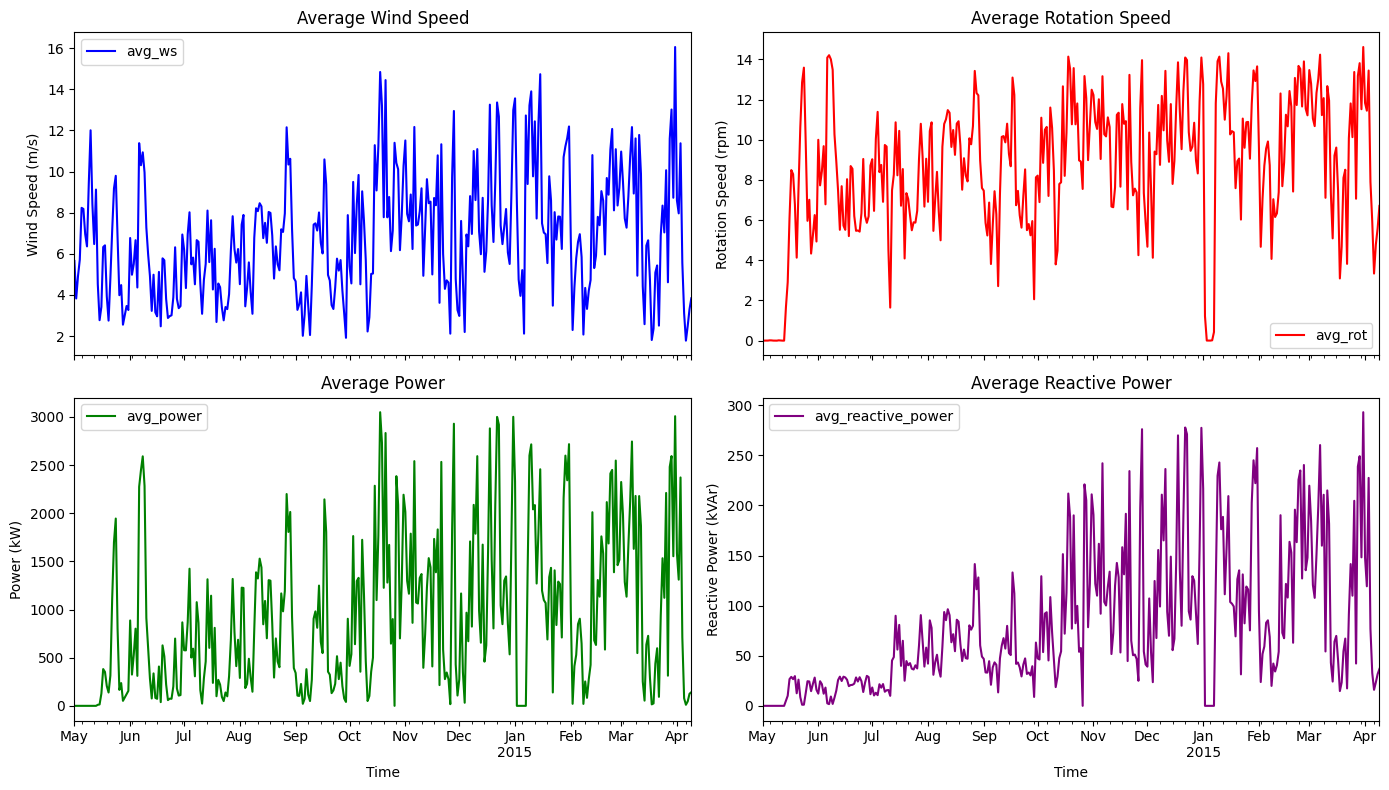

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex='col')

# Plot Average Wind Speed
ws_rot_power_features.resample('D').mean().plot(y="avg_ws", ax=axs[0, 0], color='b', title="Average Wind Speed")
axs[0, 0].set_ylabel("Wind Speed (m/s)")

# Plot Average Rotation Speed
ws_rot_power_features.resample('D').mean().plot(y="avg_rot", ax=axs[0, 1], color='r', title="Average Rotation Speed")
axs[0, 1].set_ylabel("Rotation Speed (rpm)")

# Plot Average Power
ws_rot_power_features.resample('D').mean().plot(y="avg_power", ax=axs[1, 0], color='g', title="Average Power")
axs[1, 0].set_ylabel("Power (kW)")

# Plot Average Reactive Power
ws_rot_power_features.resample('D').mean().plot(y="avg_reactive_power", ax=axs[1, 1], color='purple', title="Average Reactive Power")
axs[1, 1].set_ylabel("Reactive Power (kVAr)")

plt.tight_layout()


**Analysis**

The power generated by a wind turbine is directly affected by the rotation speed of its blades, which is itself influenced by the wind speed. This relationship is evident, as the average power, reactive power, blade rotation speed, and wind speed show synchronized fluctuations.

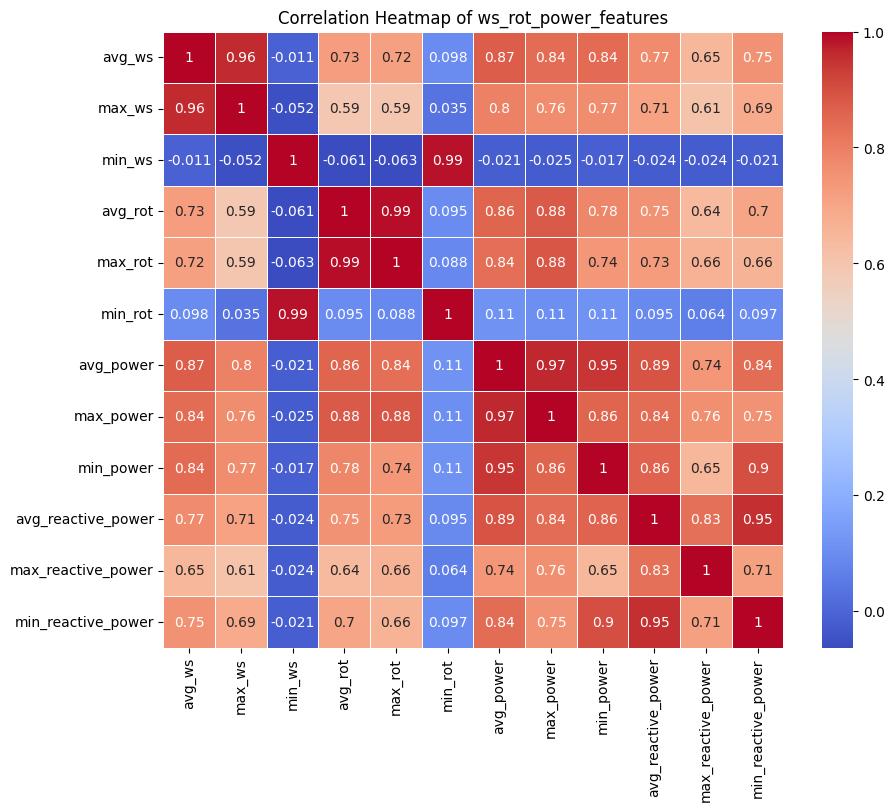

In [36]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(ws_rot_power_features.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of ws_rot_power_features')
plt.show()

The correlation matrix confirms the previous findings, showing strong correlations (over 60%) between average power, reactive power, blade rotation, and wind speed. Furthermore, there is redundancy in the maximum measurements, with correlations exceeding 90% compared to the average measurements. These redundant features should be eliminated before training the models to enhance performance.

# **Energy production**

<Axes: xlabel='Time'>

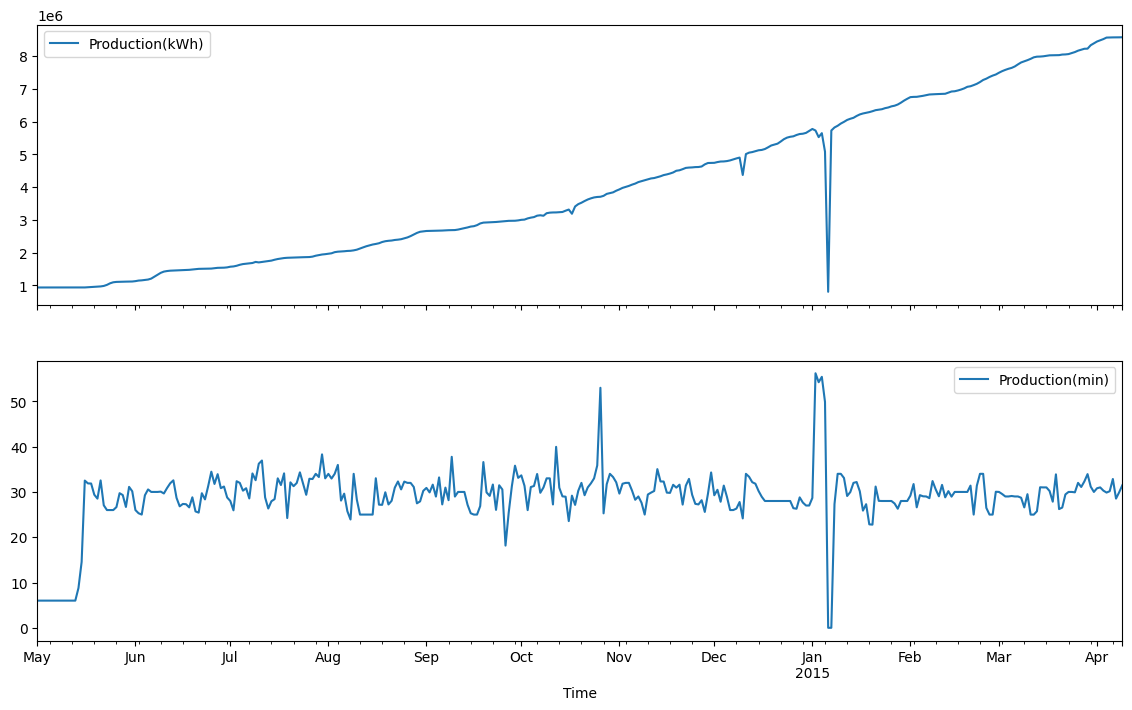

In [39]:
fig, axs = plt.subplots(2, 1, sharex='col', figsize=(14, 8))
combined_data.resample('D').mean(numeric_only=True).plot(y="Production(kWh)", ax=axs[0])
combined_data.resample('D').mean(numeric_only=True).plot(y="Production(min)", ax=axs[1])

**Analysis**

It can be seen that there are fluctuations in the total energy (kWh) generated by the turbine, and these variations are attributed to instances of failures. The most prominent occurrence is noted at the beginning of January 2015. This pattern is visually evident in the production minutes plot.

# **Energy/Power variation during faults**

<ipython-input-44-05114c4e6308>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_data, x='Fault', y='avg_power', ax=axs[0], palette='Set2')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tup

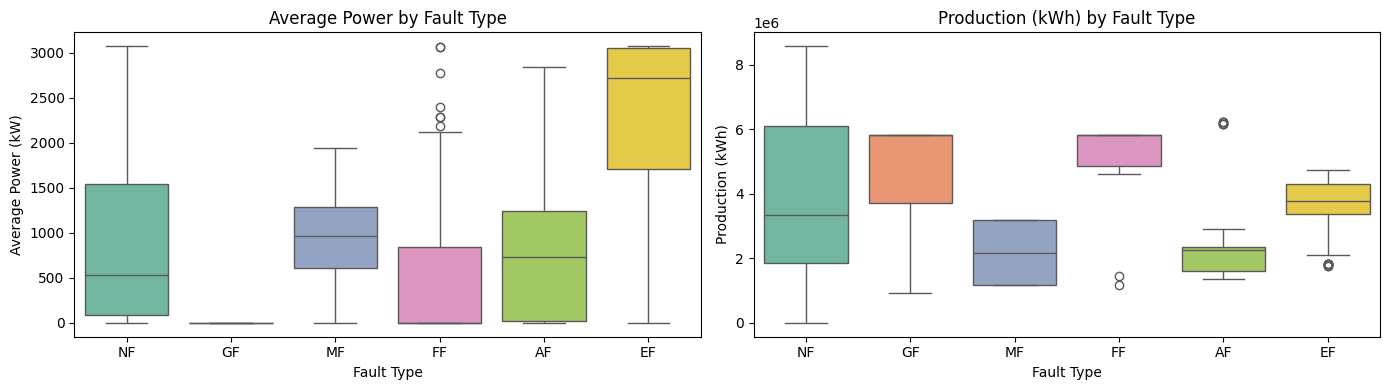

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

# Boxplot for Average Power
sns.boxplot(data=combined_data, x='Fault', y='avg_power', ax=axs[0], palette='Set2')
axs[0].set_title('Average Power by Fault Type')
axs[0].set_ylabel('Average Power (kW)')
axs[0].set_xlabel('Fault Type')

# Boxplot for Production(kWh)
sns.boxplot(data=combined_data, x='Fault', y='Production(kWh)', ax=axs[1], palette='Set2')
axs[1].set_title('Production (kWh) by Fault Type')
axs[1].set_ylabel('Production (kWh)')
axs[1].set_xlabel('Fault Type')

plt.tight_layout()
plt.show()


# **Temperature features**


In [43]:
inverters_temperatures = combined_data[['temp_inverter11', 'temp_inverter12', 'temp_inverter13', 'temp_inverter14',
                         'temp_inverter15', 'temp_inverter16', 'temp_inverter17', 'temp_inverter21',
                         'temp_inverter22', 'temp_inverter23', 'temp_inverter24', 'temp_inverter25',
                         'temp_inverter26', 'temp_inverter27', 'Fault']]

In [46]:
invert_temp_by_fault = inverters_temperatures.groupby('Fault').mean().T
df = invert_temp_by_fault.copy()

# Compute temperature percentage change for fault cases compared to non fualt cases
changes_df = df.drop(columns="NF").subtract(df["NF"], axis=0)
temp_percentage_change = changes_df.div(df['NF'], axis=0) * 100
temp_percentage_change['NF'] = invert_temp_by_fault['NF']


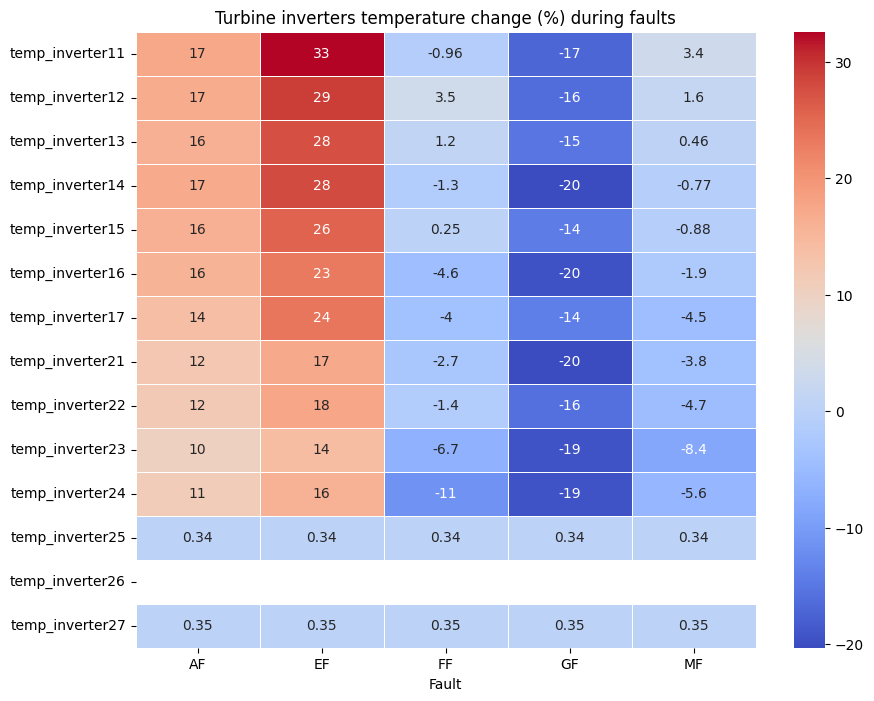

In [47]:
# plot inverters temperature percentage change during faults
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(temp_percentage_change.iloc[:, :5], annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Turbine inverters temperature change (%) during faults")
plt.show()

**Analysis**

The following anomalies have been identified regarding the temperatures of the inverters:

1. 'AF' and 'EF' Faults: In these cases, the inverter temperatures increase by over 10% compared to their normal values.

2. 'GF' Faults: During a 'GF' failure, all inverters experience a temperature drop ranging from 14% to 20%.

3. 'FF' and 'MF' Faults: For these faults, the inverter temperatures show minor changes (between 1% and 10%), either increasing or decreasing based on the specific inverter, relative to their nominal values.

4. Last Three Inverters: These inverters appear to be operating outside their normal working range. Their temperatures, both nominal and during faults, deviate significantly from those of the other inverters in the system.


<Axes: >

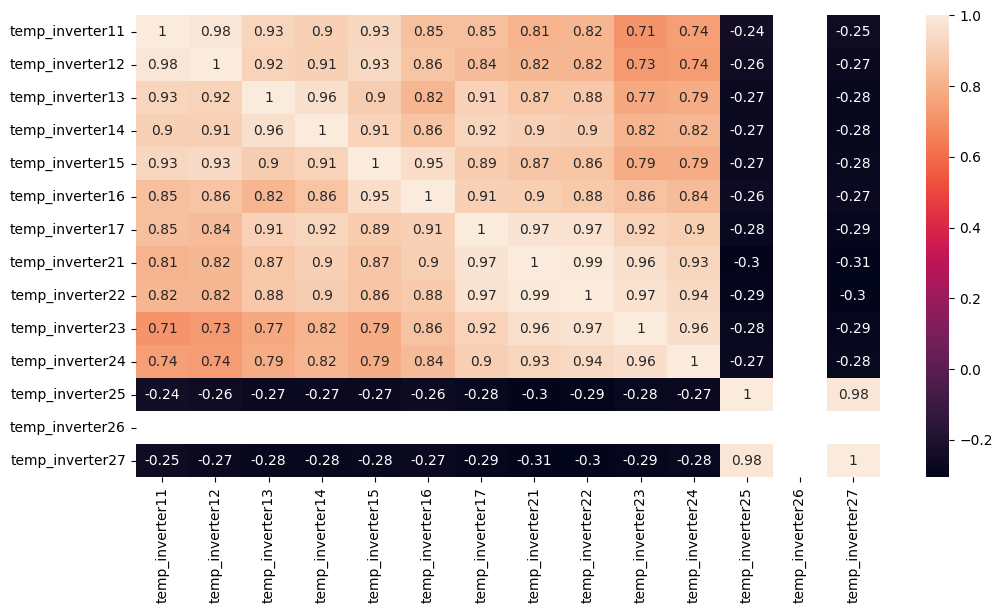

In [48]:
# Correlation
plt.figure(figsize=(12, 6))
sns.heatmap(inverters_temperatures.corr(numeric_only=True), annot=True)

**Analysis**

A strong correlation is observed among the temperature features of all inverters (excluding the last three inverters). To mitigate overfitting caused by redundant information, it will be advisable to drop some of these features when training the models.

In [49]:
# other turbine components temperatures
components_temp = combined_data[['temp_Spinner','temp_Front_bearing', 'temp_Rear_bearing', 'temp_Pitch_cabinet_blade_A',
                                   'temp_Pitch_cabinet_blade_B', 'temp_Pitch_cabinet_blade_C', 'temp_Blade_A', 'temp_Blade_B',
                                   'temp_Blade_C', 'temp_Rotor1', 'temp_Rotor2', 'temp_stator1', 'temp_stator2',
                                   'temp_nacelle_ambient1', 'temp_nacelle_ambient2','temp_nacelle', 'temp_nacelle_cabinet',
                                   'temp_main_carrier', 'temp_rectifier_cabinet', 'temp_yaw_inverter_cabinet',
                                   'temp_fan_inverter_cabinet', 'temp_ambient', 'temp_tower', 'temp_control_cabinet',
                                   'temp_Transformer', 'Fault']]

In [50]:
components_temp_by_fault = components_temp.groupby('Fault').mean().T
df = components_temp_by_fault.copy()

# Compute temperature percentage change for fault cases compared to non fualt cases
changes_df = df.drop(columns="NF").subtract(df["NF"], axis=0)
temp_percentage_change = changes_df.div(df['NF'], axis=0) * 100
temp_percentage_change['NF'] = components_temp_by_fault['NF']

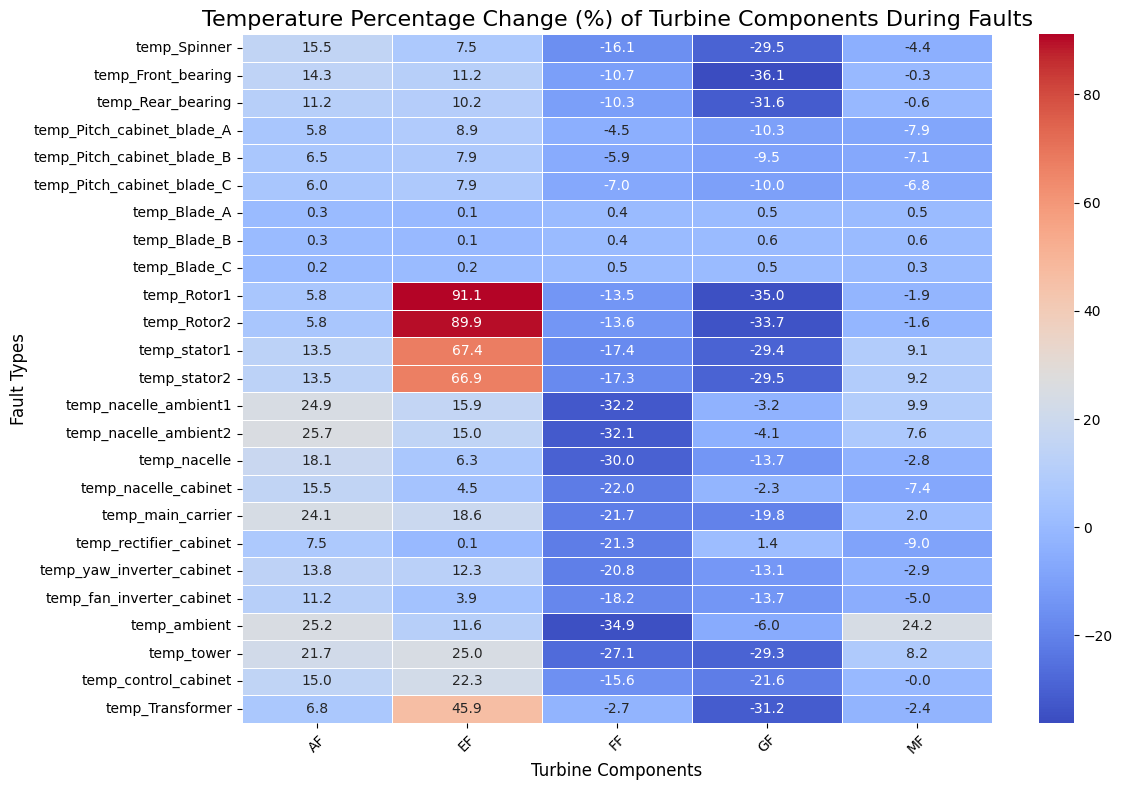

In [52]:
plt.figure(figsize=(12, 8))
sns.heatmap(temp_percentage_change.iloc[:, :5], annot=True, cmap='coolwarm', fmt='.1f', linewidths=.5)
plt.title("Temperature Percentage Change (%) of Turbine Components During Faults", fontsize=16)
plt.xlabel("Turbine Components", fontsize=12)
plt.ylabel("Fault Types", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Analysis**

As previously noted, several anomalies have been identified regarding temperature changes during different fault types. In the presence of an **AF fault**, there is a significant surge in temperatures across all components, particularly in the nacelles, tower, and main carrier, where increases exceed 25%. During an **EF fault**, substantial temperature elevations are observed in the rotors and stators, with increases of 67% and 90%, respectively, while the transformer temperature also rises by 46%. Additionally, inverter temperatures show an increase of more than 10% compared to their normal values during these faults. Conversely, both **FF and GF faults** lead to considerable decreases in component temperatures, surpassing -30%. Notably, during GF faults, significant temperature reductions are recorded in the spinner, bearings, rotors, and stators, alongside similar drops in the nacelles, tower, and rectifier. In the case of an **MF fault**, component temperatures display either a slight increase or decrease, generally within the range of 2% to 10%. Interestingly, the temperatures of the A, B, and C blades remain unaffected during these faults, indicating a potential area for further investigation.

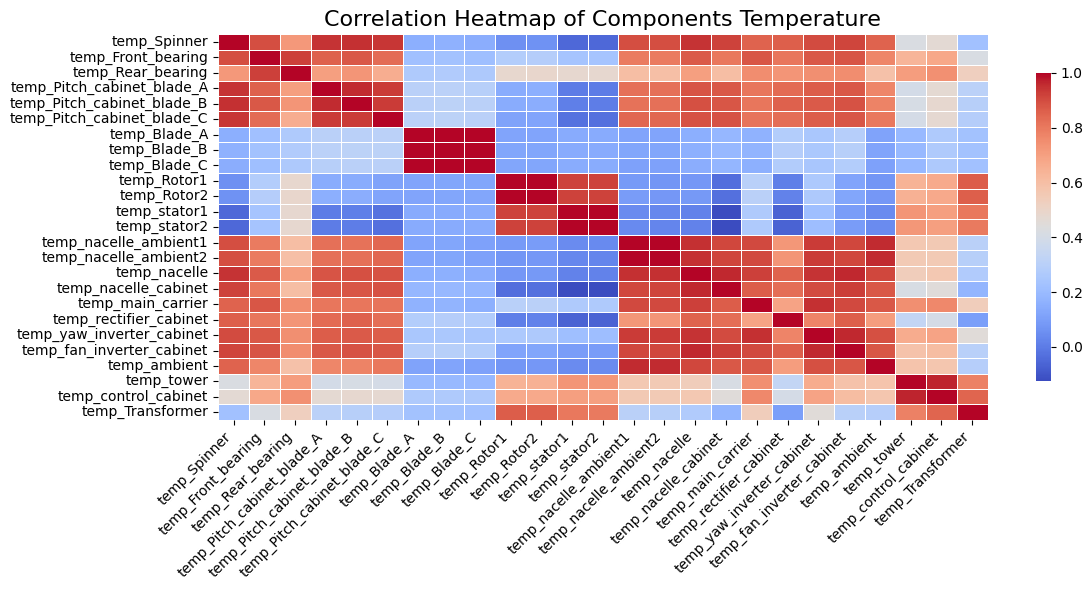

In [54]:
plt.figure(figsize=(12, 6))
corr_matrix = components_temp.corr(numeric_only=True)


sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .8})

plt.title("Correlation Heatmap of Components Temperature", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Analysis**

A strong correlation is observed among the temperature features of several components, including the temperatures of the A, B, and C blades, as well as those of the rotors, stators, and nacelles. To address this redundancy, some of these features will be considered for removal prior to training the models.

# **Features Correlation**
Let's eliminate the highly correlated features identified earlier and examine the correlation among the remaining ones.

In [55]:
data = combined_data[['avg_ws', 'min_ws', 'avg_rot','min_rot', 'avg_power', 'avg_Nacel_position',
                      'Operating Hours', 'Production(kWh)', 'Production(min)', 'avg_reactive_power',
                      'max_reactive_power', 'min_reactive_power', 'avg_blade_angle_A', 'temp_inverter11',
                      'temp_inverter13', 'temp_inverter15', 'temp_inverter17', 'temp_inverter23',
                      'temp_inverter24', 'temp_Spinner','temp_Front_bearing', 'temp_Rear_bearing',
                      'temp_Pitch_cabinet_blade_A',  'temp_Blade_A', 'temp_Rotor1', 'temp_stator1',
                      'temp_nacelle_ambient1','temp_nacelle',  'temp_main_carrier', 'temp_rectifier_cabinet',
                      'temp_yaw_inverter_cabinet',  'temp_fan_inverter_cabinet', 'temp_ambient', 'temp_tower',
                      'temp_Transformer', 'avg_RTU_setpoint1', 'Inverter averages', 'Inverter std dev', 'Fault']]

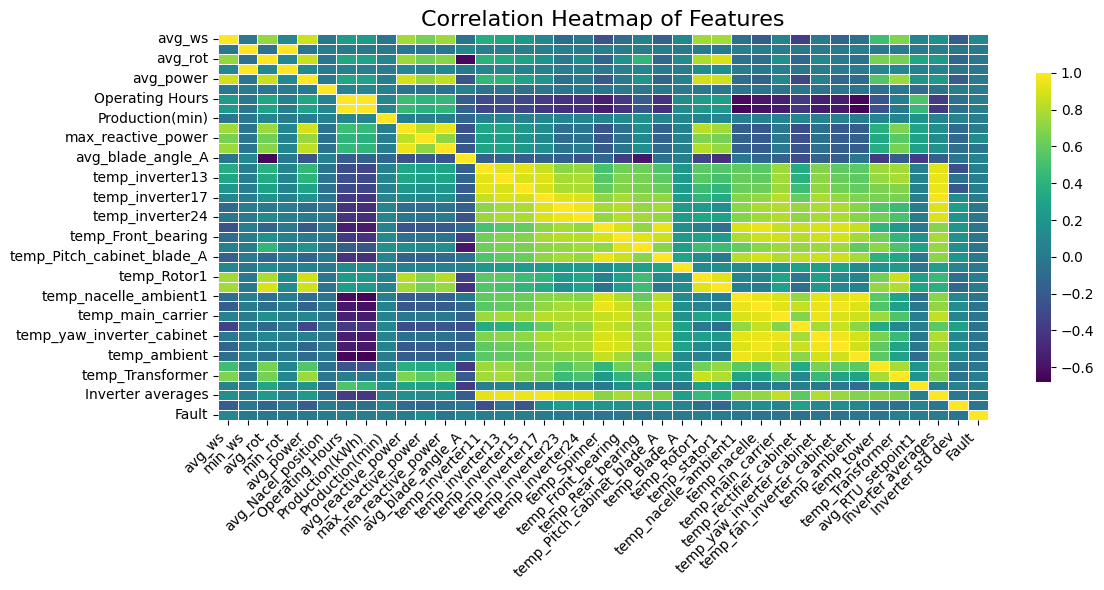

In [56]:
df = data.copy()
df["Fault"] = df["Fault"].map({"NF": 0, "AF": 1, "EF": 2, "FF": 3, "GF": 4, "MF": 5})

plt.figure(figsize=(12, 6))
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=False, cmap='viridis', linewidths=.5, cbar_kws={"shrink": .8})

plt.title("Correlation Heatmap of Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# **Data preprocessing**

As we've seen our dataset is heavily imbalanced, so we must first take a smaller sample of the non faults instances and then try the models training.

In [57]:
df = data.copy()
df_with_faults = df[df.Fault != "NF"]
df_with_faults.shape

(446, 39)

In [59]:
df_no_faults = df[df.Fault == "NF"].sample(400, random_state=0)

In [60]:
df = pd.concat([df_no_faults, df_with_faults], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

In [61]:
target = df["Fault"]
X = df.drop(["Fault"], axis=1)

In [62]:
# we must first encode our fault classes into numerical values
encoder = LabelEncoder()
Y = encoder.fit_transform(target)

In [63]:
# Split the dataset: Training(80%), Testing(20%)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [64]:
# Scale features for models training
def scale_features(x_train, x_test):
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train =  scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train, x_test

In [65]:
x_train, x_test = scale_features(x_train, x_test)

In [66]:
classes_labels = list(encoder.classes_)

# keep track of precision, recall scores
precision_scores = {}
recall_scores = {}

def plot_classification_result(model, y_test, y_pred):
    precision_scores[model] = np.round(np.array(precision_score(y_test, y_pred, average=None, zero_division=0)), 2)
    recall_scores[model] = np.round(np.array(recall_score(y_test, y_pred, average=None)), 2)
    print("Average accuracy score: ", accuracy_score(y_test, y_pred))
    print("Metrics table:\n", classification_report(y_test, y_pred, target_names=classes_labels, zero_division=0))
    print("Confusion matrix:\n")
    matrix = confusion_matrix(y_test, y_pred)
    matrix = pd.DataFrame(matrix, index=classes_labels, columns=classes_labels)
    plt.figure(figsize=(6, 4))
    plot = sns.heatmap(matrix, fmt='.2f', annot=True)
    plot.set_xlabel('Predicted')
    plot.set_ylabel('Real')

# **Building ML models**
# **Logistic Regression Classifier**


In [67]:
lrg_clf = LogisticRegression(multi_class='auto', max_iter=1000)
lrg_clf.fit(x_train, y_train)
y_pred = lrg_clf.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Average accuracy score:  0.8470588235294118
Metrics table:
               precision    recall  f1-score   support

          AF       0.83      0.36      0.50        14
          EF       0.74      1.00      0.85        34
          FF       0.97      0.84      0.90        37
          GF       1.00      1.00      1.00         7
          MF       0.00      0.00      0.00         1
          NF       0.85      0.87      0.86        77

    accuracy                           0.85       170
   macro avg       0.73      0.68      0.68       170
weighted avg       0.85      0.85      0.84       170

Confusion matrix:



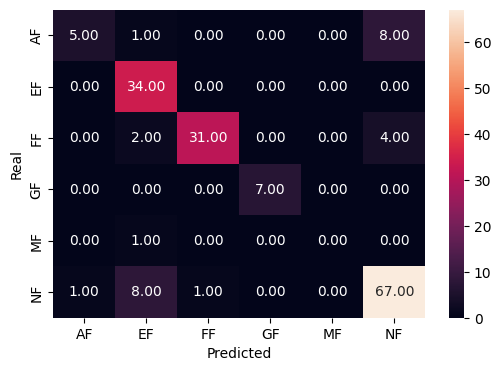

In [68]:
plot_classification_result("Logistic regression", y_test, y_pred)

**Analysis**

The logistic regression model achieved a commendable overall accuracy of 87%. However, it struggles with classifying AF faults, resulting in an F1 score of only 59%. Additionally, the classifier fails to effectively learn the characteristics of the MF fault, primarily due to the limited number of instances (only 8) available for this fault type. To address this issue, the implementation of an oversampling technique should be considered.

# **Support Vector Machine**

In [69]:
svc_clf = SVC()
svc_clf.fit(x_train, y_train)
y_pred = svc_clf.predict(x_test)

Average accuracy score:  0.8117647058823529
Metrics table:
               precision    recall  f1-score   support

          AF       0.75      0.21      0.33        14
          EF       0.76      1.00      0.86        34
          FF       0.93      0.73      0.82        37
          GF       1.00      1.00      1.00         7
          MF       0.00      0.00      0.00         1
          NF       0.79      0.87      0.83        77

    accuracy                           0.81       170
   macro avg       0.70      0.64      0.64       170
weighted avg       0.81      0.81      0.79       170

Confusion matrix:



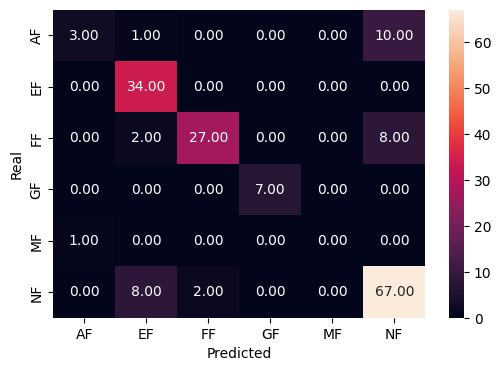

In [70]:
plot_classification_result("SVC", y_test, y_pred)

**Analysis**

The SVC model yields a lower accuracy of 88% and faces even greater challenges in classifying AF faults, achieving an F1 score of just 27%. Similar to the logistic regression model, the SVC also struggles to learn about the MF fault due to the same issue of insufficient instances.

# **Decision Tree Classifier**

In [73]:
tree_clf = DecisionTreeClassifier(random_state=1)
tree_clf.fit(x_train, y_train)
y_pred = tree_clf.predict(x_test)

Average accuracy score:  0.8117647058823529
Metrics table:
               precision    recall  f1-score   support

          AF       0.47      0.57      0.52        14
          EF       0.84      0.94      0.89        34
          FF       0.94      0.86      0.90        37
          GF       0.88      1.00      0.93         7
          MF       0.00      0.00      0.00         1
          NF       0.83      0.77      0.80        77

    accuracy                           0.81       170
   macro avg       0.66      0.69      0.67       170
weighted avg       0.82      0.81      0.82       170

Confusion matrix:



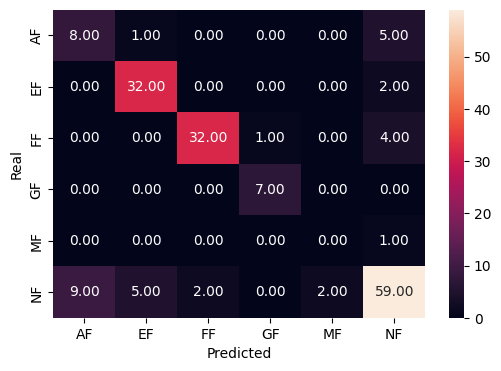

In [74]:
plot_classification_result("Decision tree", y_test, y_pred)

**Analysis**

The decision tree model gives a higher overall accuracy of 88%, and it produce similair performance as the logistic regression model in the classification of the AF faults with an f1 score of 57%. And the model is not able to classify the MF fault.

# **Random Forest Classifier**

In [75]:
rf_clf = RandomForestClassifier(n_estimators=200, random_state=1)
rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)

Average accuracy score:  0.8823529411764706
Metrics table:
               precision    recall  f1-score   support

          AF       0.86      0.43      0.57        14
          EF       0.82      0.97      0.89        34
          FF       1.00      0.89      0.94        37
          GF       1.00      1.00      1.00         7
          MF       0.00      0.00      0.00         1
          NF       0.86      0.92      0.89        77

    accuracy                           0.88       170
   macro avg       0.76      0.70      0.72       170
weighted avg       0.88      0.88      0.87       170

Confusion matrix:



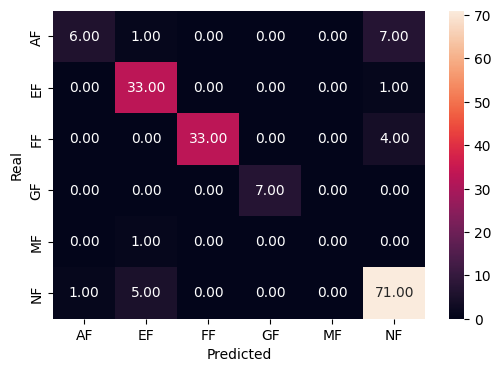

In [76]:
plot_classification_result("Random forest", y_test, y_pred)

**Analysis**


The Random Forest model produced the highest accuracy score so far 93.5%, it gives good F1 scores across all fault classes, but the model is not able to classify the MF fault at all.

# **Results analysis**


**Models Precision results**

In [77]:
precision_results = pd.DataFrame(precision_scores, index=classes_labels)
precision_results.T

,AF,EF,FF,GF,MF,NF
Logistic regression,0.83,0.74,0.97,1.00,0.0,0.85
SVC,0.75,0.76,0.93,1.00,0.0,0.79
Decision tree,0.47,0.84,0.94,0.88,0.0,0.83
Random forest,0.86,0.82,1.00,1.00,0.0,0.86


**Models Recall results**

In [78]:
recall_results = pd.DataFrame(recall_scores, index=classes_labels)
recall_results.T

,AF,EF,FF,GF,MF,NF
Logistic regression,0.36,1.00,0.84,1.0,0.0,0.87
SVC,0.21,1.00,0.73,1.0,0.0,0.87
Decision tree,0.57,0.94,0.86,1.0,0.0,0.77
Random forest,0.43,0.97,0.89,1.0,0.0,0.92


**Analysis**

All the models demonstrated strong overall accuracy, exceeding 87%, with the random forest model achieving the highest accuracy at 93%. However, the models struggled to learn about the MF fault class due to its limited representation in the dataset. To address this issue, the implementation of an oversampling technique should be considered.

# **Rebalance Data with SMOTE**

The trained models faced challenges in accurately classifying certain fault classes due to their inadequate representation in the dataset. To address this issue, we will implement the SMOTE algorithm (Synthetic Minority Oversampling Technique) to oversample the minority classes present in our dataset.

In [79]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [80]:
X

,avg_ws,min_ws,avg_rot,min_rot,avg_power,avg_Nacel_position,Operating Hours,Production(kWh),Production(min),avg_reactive_power,...,temp_main_carrier,temp_rectifier_cabinet,temp_yaw_inverter_cabinet,temp_fan_inverter_cabinet,temp_ambient,temp_tower,temp_Transformer,avg_RTU_setpoint1,Inverter averages,Inverter std dev
0,9.2,6.4,1.69,1.52,0,300,5873,5812312,57,0,...,12,21,17,21,7,12,36,3050,25.181818,1.401298
1,8.8,6.4,12.29,10.29,1884,-28,6395,6685669,13,176,...,10,21,18,20,4,24,55,3050,25.818182,1.401298
2,8.9,7.1,12.28,10.77,1825,-19,6420,6748918,13,165,...,9,19,16,19,3,22,46,3050,23.454546,1.694912
3,4.4,3.7,7.02,6.90,184,-183,7834,8574788,9,39,...,18,36,27,34,12,18,35,3050,24.909090,3.207945
4,6.8,5.9,10.02,9.69,837,-69,4960,4591564,39,72,...,15,28,22,26,11,24,42,3050,26.636364,1.286291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,9.3,6.7,12.26,10.85,1787,112,3597,2911989,39,104,...,24,31,31,35,19,33,53,3050,33.454544,1.439697
842,3.7,0.4,0.62,0.00,0,-371,2966,2366840,2,1,...,20,40,28,34,17,24,41,3033,30.818182,1.721522
843,9.0,1.9,4.15,0.00,359,-360,2918,2340966,25,40,...,22,32,27,32,17,29,46,3033,33.636364,1.026911
844,13.3,6.6,9.62,1.24,1708,-189,5070,4635464,10,168,...,15,26,24,26,12,25,60,3037,30.181818,1.940009


In [81]:
Y

array([2, 5, 5, 5, 5, 2, 1, 1, 1, 5, 1, 5, 2, 5, 5, 5, 5, 5, 5, 5, 1, 3,
       5, 5, 2, 0, 5, 5, 5, 5, 2, 0, 5, 1, 1, 2, 2, 2, 5, 2, 5, 5, 5, 1,
       2, 1, 0, 5, 0, 5, 2, 5, 2, 5, 1, 0, 1, 5, 0, 1, 5, 4, 2, 1, 2, 2,
       2, 2, 5, 5, 5, 5, 2, 5, 1, 2, 5, 0, 5, 5, 5, 1, 2, 1, 5, 2, 5, 4,
       5, 1, 2, 5, 2, 3, 5, 5, 4, 2, 5, 5, 5, 2, 5, 5, 1, 1, 5, 2, 5, 5,
       2, 1, 5, 0, 2, 5, 5, 2, 1, 5, 5, 2, 5, 3, 1, 1, 5, 5, 1, 1, 2, 2,
       2, 5, 1, 5, 5, 0, 0, 1, 2, 0, 2, 5, 2, 2, 3, 2, 2, 5, 2, 1, 1, 2,
       5, 5, 5, 5, 2, 1, 5, 1, 5, 2, 5, 1, 5, 5, 5, 2, 0, 5, 2, 5, 2, 1,
       2, 2, 2, 5, 5, 1, 0, 5, 2, 5, 5, 0, 5, 0, 1, 5, 5, 5, 2, 0, 5, 1,
       2, 2, 5, 1, 5, 5, 1, 5, 1, 5, 1, 1, 1, 5, 0, 5, 2, 1, 5, 5, 2, 5,
       5, 5, 5, 0, 5, 5, 1, 5, 5, 3, 2, 5, 1, 1, 0, 0, 3, 5, 5, 1, 5, 2,
       2, 5, 1, 5, 5, 2, 3, 3, 3, 5, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 1,
       1, 3, 5, 5, 5, 5, 1, 2, 5, 5, 5, 1, 1, 5, 5, 5, 1, 2, 0, 5, 3, 1,
       1, 1, 2, 1, 5, 5, 5, 5, 1, 5, 1, 0, 5, 2, 5,

In [82]:
smt = SMOTE(random_state=0)
print("Before classes count:", Counter(Y))
X_bal, Y_bal = smt.fit_resample(X, Y)
print("After classes count:",Counter(Y_bal))

Before classes count: Counter({5: 400, 1: 174, 2: 159, 0: 62, 3: 43, 4: 8})
After classes count: Counter({2: 400, 5: 400, 1: 400, 3: 400, 0: 400, 4: 400})


In [83]:
# Split the dataset: Training(80%), Testing(20%)
x_train, x_test, y_train, y_test = train_test_split(X_bal, Y_bal, test_size=0.2, random_state=0)

# apply scaling to X features
x_train, x_test = scale_features(x_train, x_test)

# **Logistic Regression**

In [84]:
lrg_clf = LogisticRegression(multi_class='auto', max_iter=1000)
lrg_clf.fit(x_train, y_train)
y_pred = lrg_clf.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Average accuracy score:  0.95
Metrics table:
               precision    recall  f1-score   support

          AF       0.89      0.93      0.91        86
          EF       0.96      1.00      0.98        79
          FF       0.99      1.00      0.99        77
          GF       1.00      1.00      1.00        79
          MF       0.95      1.00      0.97        74
          NF       0.92      0.79      0.85        85

    accuracy                           0.95       480
   macro avg       0.95      0.95      0.95       480
weighted avg       0.95      0.95      0.95       480

Confusion matrix:



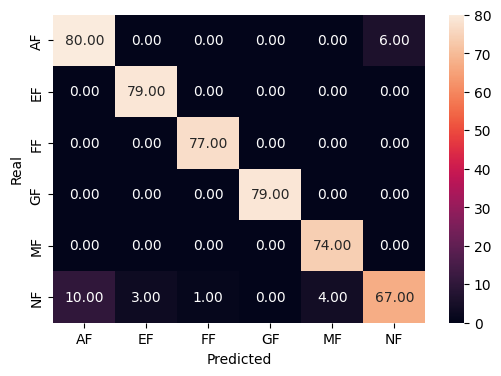

In [85]:
plot_classification_result("Logistic regression", y_test, y_pred)

**Analysis**


The logistic regression model achieved an impressive overall accuracy of 96% and successfully classified all classes with an F1 score of 78% or higher, indicating that the oversampling technique had a positive effect. However, it is noted that the model's performance on the NF class was not as strong compared to the other classes.

# **Support Vector Machine**

In [86]:
svc_clf = SVC()
svc_clf.fit(x_train, y_train)
y_pred = svc_clf.predict(x_test)

Average accuracy score:  0.9229166666666667
Metrics table:
               precision    recall  f1-score   support

          AF       0.80      0.94      0.87        86
          EF       0.91      1.00      0.95        79
          FF       0.97      1.00      0.99        77
          GF       1.00      1.00      1.00        79
          MF       0.97      1.00      0.99        74
          NF       0.91      0.62      0.74        85

    accuracy                           0.92       480
   macro avg       0.93      0.93      0.92       480
weighted avg       0.93      0.92      0.92       480

Confusion matrix:



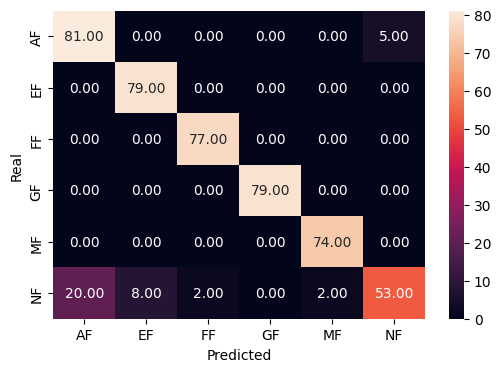

In [87]:
plot_classification_result("SVC", y_test, y_pred)

# **Decision Tree Classifier**

In [88]:
tree_clf = DecisionTreeClassifier(random_state=1)
tree_clf.fit(x_train, y_train)
y_pred = tree_clf.predict(x_test)

Average accuracy score:  0.95
Metrics table:
               precision    recall  f1-score   support

          AF       0.93      0.93      0.93        86
          EF       0.94      0.97      0.96        79
          FF       0.95      0.99      0.97        77
          GF       1.00      1.00      1.00        79
          MF       0.99      0.99      0.99        74
          NF       0.90      0.84      0.87        85

    accuracy                           0.95       480
   macro avg       0.95      0.95      0.95       480
weighted avg       0.95      0.95      0.95       480

Confusion matrix:



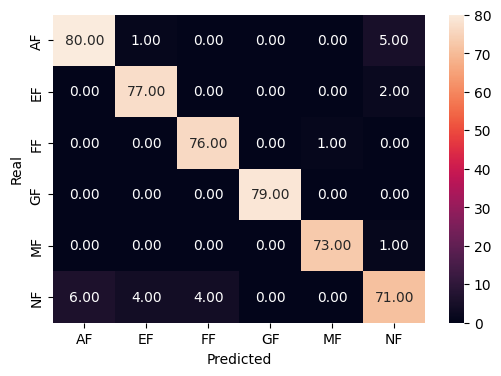

In [89]:
plot_classification_result("Decision tree", y_test, y_pred)

**Analysis**


Both the SVC and decision tree models achieved a higher accuracy score of 96% and were able to predict all classes with exceptionally high F1 scores exceeding 90%. However, similar to the logistic regression model, both models faced difficulties in accurately predicting the NF class, achieving recall scores of only 78% and 79%, respectively, in this particular category.

# **Random Forest Classifier**

In [90]:
rf_clf = RandomForestClassifier(n_estimators=200, random_state=1)
rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)

Average accuracy score:  0.9729166666666667
Metrics table:
               precision    recall  f1-score   support

          AF       0.96      0.99      0.97        86
          EF       0.96      1.00      0.98        79
          FF       0.96      0.99      0.97        77
          GF       1.00      1.00      1.00        79
          MF       0.97      1.00      0.99        74
          NF       0.99      0.87      0.93        85

    accuracy                           0.97       480
   macro avg       0.97      0.97      0.97       480
weighted avg       0.97      0.97      0.97       480

Confusion matrix:



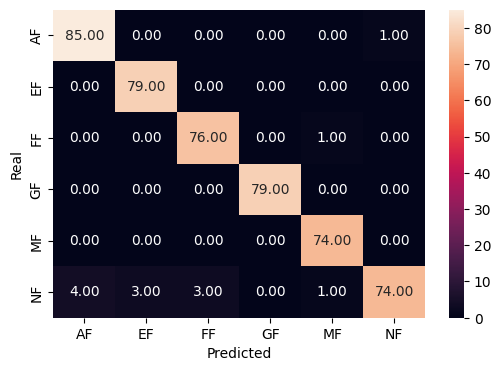

In [91]:
plot_classification_result("Random forest", y_test, y_pred)

**Analysis**

The Random Forest model achieved the highest accuracy score to date at 98.5% and demonstrated strong predictive capabilities, providing high F1 scores across all fault classes, all exceeding 95%.

# **Results analysis**

**Models Precision results**

In [92]:
precision_results = pd.DataFrame(precision_scores, index=classes_labels)
precision_results.T

,AF,EF,FF,GF,MF,NF
Logistic regression,0.89,0.96,0.99,1.0,0.95,0.92
SVC,0.80,0.91,0.97,1.0,0.97,0.91
Decision tree,0.93,0.94,0.95,1.0,0.99,0.90
Random forest,0.96,0.96,0.96,1.0,0.97,0.99


**Models Recall results**

In [93]:
recall_results = pd.DataFrame(recall_scores, index=classes_labels)
recall_results.T

,AF,EF,FF,GF,MF,NF
Logistic regression,0.93,1.00,1.00,1.0,1.00,0.79
SVC,0.94,1.00,1.00,1.0,1.00,0.62
Decision tree,0.93,0.97,0.99,1.0,0.99,0.84
Random forest,0.99,1.00,0.99,1.0,1.00,0.87


**Final Comments**

The implementation of the SMOTE oversampling technique significantly improved the accuracy of all models, with the lowest score exceeding 93%. Notably, all models exhibited accurate predictions across all fault classes within the dataset. Among them, the Random Forest model remained the top performer, achieving the highest accuracy of 98.5%.